# OLR moving to the TOA

Use the different OLR fields in CESM1 to understand what processes are controlling OLR trends and variability.

1. OLR at the surface: This should only be mediated by surface temperature and surface emissivity (i.e. surface type).

2. Clear-sky TOA OLR: This is now mediated by atmospheric properties as well. The most important effect should be water vapor I would expect.

3. All-sky TOA OLR: Now we add the effect of clouds.

__Previous notes:__

Thinking ahead about the next critical figure where we compare OLR by layer. I want to try and pinpoint where the forced trends and internal variability are coming from as the OLR moves from the surface through the atmosphere and out to space.

When I previously compared emergence times of TOA OLR to TS, the fall emergence was similar, while the spring was significantly delayed. This indicates that the atmosphere/clouds is either: 1. Adding variability in the spring such that forced trends become difficult to distinguish from internal variability, or 2. The atmosphere is actually damping the forced trends themselves. I hypothesize that both are true, but 1. Is the dominant source of differences since internal variability seems to be the culprit when comparing variability estimated from the PI-Control simulation.

Our first column in this new plot will be a 95% confidence interval on OLR trends at the surface (April vs. September). This depends on surface temperature and surface emissivity changes, though I am doubtful that the surface emissivity changes have a large contribution.

The second column in this new plot will be a 95% confidence interval on TOA OLR trends for clear-sky (April vs. September). When compared to the first column this will show how the atmosphere mediates OLR trends and variability.

The third column in this new plot will be a 95% confidence interval on TOA all-sky OLR trends (April vs. September). When compared to the second and first column, this will tell us how clouds mediate OLR trends and variability.


### Do imports

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/Common/') # is this good or not good. I should reorg.
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    np, xr, plt, sns, os, 
    datetime, gridspec, 
    Iterable, cmaps, glob, copy,
    dask,pd
    )

from functions import (
    add_weights,
    to_png, stats, fix_cesm_time
    )

from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

CERES OLR obs.

In [2]:
ceres_data_dir = '/glade/u/home/jonahshaw/w/obs/CERES/arc_proc/'
ceres_arctseries_file = 'CERES_EBAF4.1_TOAvarsonly_200003_202202_ArcticTimeSeries.nc'

In [3]:
ceres_arctseries_ds = xr.open_dataset('%s/%s' % (ceres_data_dir,ceres_arctseries_file))

### Load pre-processed timeseries

Model output.

In [4]:
tseries_savedir = '/glade/u/home/jonahshaw/w/LENS/CESM1-LE/ArcticTimeSeries/'

# cesm1_pic_ds = xr.open_dataset('%s/CESM1_PIControl_ArcticTimeSeries.nc' % tseries_savedir)
cesm1_ensresponse_ds = xr.open_dataset('%s/CESM1_RCP8.5Members_ArcticTimeSeries.nc' % tseries_savedir)
cesm1_pic_ds = xr.open_dataset('%s/CESM1_PIControl_ArcticTimeSeries.nc' % tseries_savedir)

In [5]:
cesm1_ensresponse_olr  = cesm1_ensresponse_ds['FLUT'] # all-sky OLR
cesm1_ensresponse_olrc = cesm1_ensresponse_ds['FLUTC'] # clear-sky OLR
cesm1_ensresponse_olrs = cesm1_ensresponse_ds['FLDS'] - cesm1_ensresponse_ds['FLNS'] # surface OLR (but I'm not sure why this gives the right values)

In [6]:
cesm1_pic_olr  = cesm1_pic_ds['FLUT'] # all-sky OLR
cesm1_pic_olrc = cesm1_pic_ds['FLUTC'] # clear-sky OLR
cesm1_pic_olrs = cesm1_pic_ds['FLDS'] - cesm1_pic_ds['FLNS'] # surface OLR (but I'm not sure why this gives the right values)

Select 25- and 50-year periods beginning in 2001.

In [7]:
cesm1_ensresponse_olr_2001_2025 = cesm1_ensresponse_olr.sel(time=slice('2001','2025'))
cesm1_ensresponse_olr_2001_2050 = cesm1_ensresponse_olr.sel(time=slice('2001','2050'))

cesm1_ensresponse_olrc_2001_2025 = cesm1_ensresponse_olrc.sel(time=slice('2001','2025'))
cesm1_ensresponse_olrc_2001_2050 = cesm1_ensresponse_olrc.sel(time=slice('2001','2050'))

cesm1_ensresponse_olrs_2001_2025 = cesm1_ensresponse_olrs.sel(time=slice('2001','2025'))
cesm1_ensresponse_olrs_2001_2050 = cesm1_ensresponse_olrs.sel(time=slice('2001','2050'))

In [8]:
# need a wrapper function because you can't groupby multiple dimensions
def gettrends_wrapper(dataarray,dim):
    
    dataarray[dim] = dataarray['time.year']
    return dataarray.groupby('ens').map(xr.DataArray.polyfit,dim=dim,deg=1)['polyfit_coefficients'].sel(degree=1)

In [9]:
def calc_confidence_interval(data,CI):
    '''
    Calculate a confidence interval on data
    $$ \mu = \bar{x} \pm z_{\alpha/2} \frac{\sigma}{\sqrt{N}} $$
    '''
    
    alpha = 1 - CI
    N = data.shape[0]
    
    t_crit = np.abs(stats.t.ppf(alpha/2,df=N)) # calculate a critical t-statistic
    
    mean = np.mean(data)
    std  = np.std(data)
    
    # Calculate the bounds of the confidence interval
    low  = mean - t_crit*std # / np.sqrt(N-1) # <-- decision about this
    high = mean + t_crit*std # / np.sqrt(N-1)
    
    bounds_da = xr.DataArray(
        data=np.array([low,high]),
        dims=["bound"],
        coords=dict(
            bound=[0,1]
        ),
    # name = 'wat'
    )
    
    return bounds_da

In [10]:
# Define a function for standardizing data to be used before calculating an autocorrelation
def standardize(data):
    ''' Standardize the data. '''
    
    if data.std()==0: # edge case that the standard deviation is zero
        data_std = (data - data.mean())
        np.testing.assert_allclose(data_std.mean(),0,atol=1e-5)
        return data_std
    else:
        data_std = (data - data.mean()) / data.std()
    
    try:
        np.testing.assert_allclose(data_std.mean(),0,atol=1e-5)
        np.testing.assert_allclose(data_std.std(),1,atol=1e-5)
    except:
        print(data_std[np.isnan(data_std)])
        print(data_std.nanmean())
        print(data_std.nanstd())
        raise AssertionError()
    
    return data_std

In [11]:
def calc_tauvar2(autocorr,alpha=0.95):
    '''
    Calculate the autocorrelation time using Leroy (2008), with a selection of significant lags following Phojan.
    Taking sample coefficients at all available lags in estimating Leroy’s uncertainty of the trend will provide zero uncertainty;
    specifically, [the sum of the lagged correlations] is zero. Therefore, it is necessary to set up the criterion to determine which
    sample autocorrelation coefficients to include in the computation. The criterion used in this study is to
    include only the statistically significant [at 95%] coefficients up to 10 log10(T) lags in the summation.
    '''
    
    # the length of the autocorrelation is equal to the length of the timeseries
    N = len(autocorr)
    
    # lags up to "10 log10(T) lags in the summation"
    max_lag = int(10*np.log10(N))
    
    # Select autocorrelation only within a "max lag" of lag-0
    valid_autocorrs = autocorr[N//2-max_lag:N//2+max_lag+1]
    
    # calculate a critical t-statistic
    t_crit = stats.t.ppf((1+alpha)/2,df=N)

    # Calculate the statistical significance bound
    # $$ bound = t_{crit} / \sqrt{N}
    correlation_bound = t_crit / np.sqrt(N)
    
    # check if the autocorrelations are significant
    is_sig_bool = np.abs(valid_autocorrs) > correlation_bound

    # select the significant correlations and sum them to get the correlation time
    tau_var = np.sum(valid_autocorrs[is_sig_bool])
    
    return tau_var

def calc_autocorr(data):
        
    # standardize the data
    data_std = standardize(data) # Standardize the timeseries so the autocorrelation has correct units
    autocorr = np.correlate(data_std,data_std,mode='same') / len(data_std)
    
    return autocorr

def calc_tauvar_wrapper2(data):
    
    return xr.DataArray(calc_tauvar2(calc_autocorr(data)))

Calculate trends for each month.

In [12]:
cesm1_olr_trends_2001_2025 = cesm1_ensresponse_olr_2001_2025.groupby('time.month').map(gettrends_wrapper,dim='time').drop('degree')
cesm1_olr_trends_2001_2050 = cesm1_ensresponse_olr_2001_2050.groupby('time.month').map(gettrends_wrapper,dim='time').drop('degree')

cesm1_olrc_trends_2001_2025 = cesm1_ensresponse_olrc_2001_2025.groupby('time.month').map(gettrends_wrapper,dim='time').drop('degree')
cesm1_olrc_trends_2001_2050 = cesm1_ensresponse_olrc_2001_2050.groupby('time.month').map(gettrends_wrapper,dim='time').drop('degree')

cesm1_olrs_trends_2001_2025 = cesm1_ensresponse_olrs_2001_2025.groupby('time.month').map(gettrends_wrapper,dim='time').drop('degree')
cesm1_olrs_trends_2001_2050 = cesm1_ensresponse_olrs_2001_2050.groupby('time.month').map(gettrends_wrapper,dim='time').drop('degree')

Calculate 95% confidence intervals on the trends.

In [13]:
cesm1_olr_CI_2001_2025 = cesm1_olr_trends_2001_2025.groupby('month').map(calc_confidence_interval,CI=0.95)
cesm1_olr_CI_2001_2050 = cesm1_olr_trends_2001_2050.groupby('month').map(calc_confidence_interval,CI=0.95)

cesm1_olrc_CI_2001_2025 = cesm1_olrc_trends_2001_2025.groupby('month').map(calc_confidence_interval,CI=0.95)
cesm1_olrc_CI_2001_2050 = cesm1_olrc_trends_2001_2050.groupby('month').map(calc_confidence_interval,CI=0.95)

cesm1_olrs_CI_2001_2025 = cesm1_olrs_trends_2001_2025.groupby('month').map(calc_confidence_interval,CI=0.95)
cesm1_olrs_CI_2001_2050 = cesm1_olrs_trends_2001_2050.groupby('month').map(calc_confidence_interval,CI=0.95)

Calculate $\sigma_{var}$ and $\tau_{var}$ for OLR, OLRC, and OLRS.

In [15]:
cesm1_olr_tauvar = cesm1_pic_olr.groupby('time.month').map(calc_tauvar_wrapper2)
cesm1_olr_stddev = cesm1_pic_olr.groupby('time.month').std()

cesm1_olrc_tauvar = cesm1_pic_olrc.groupby('time.month').map(calc_tauvar_wrapper2)
cesm1_olrc_stddev = cesm1_pic_olrc.groupby('time.month').std()

cesm1_olrs_tauvar = cesm1_pic_olrs.groupby('time.month').map(calc_tauvar_wrapper2)
cesm1_olrs_stddev = cesm1_pic_olrs.groupby('time.month').std()

Assemble mean and confidence interval data into pseudo timeseries for plotting.

Calculate the "forced" trend.

In [16]:
cesm1_olr_avgtrend_2001_2025 = cesm1_olr_trends_2001_2025.mean(dim='ens').assign_coords({'bound':2}).expand_dims('bound',axis=1)
cesm1_olr_avgtrend_2001_2050 = cesm1_olr_trends_2001_2050.mean(dim='ens').assign_coords({'bound':2}).expand_dims('bound',axis=1)

cesm1_olrc_avgtrend_2001_2025 = cesm1_olrc_trends_2001_2025.mean(dim='ens').assign_coords({'bound':2}).expand_dims('bound',axis=1)
cesm1_olrc_avgtrend_2001_2050 = cesm1_olrc_trends_2001_2050.mean(dim='ens').assign_coords({'bound':2}).expand_dims('bound',axis=1)

cesm1_olrs_avgtrend_2001_2025 = cesm1_olrs_trends_2001_2025.mean(dim='ens').assign_coords({'bound':2}).expand_dims('bound',axis=1)
cesm1_olrs_avgtrend_2001_2050 = cesm1_olrs_trends_2001_2050.mean(dim='ens').assign_coords({'bound':2}).expand_dims('bound',axis=1)

Combine forced trends and the confidence interval into a single dataarray object.

In [17]:
cesm1_olr_bounds_2001_2025 = xr.concat([cesm1_olr_avgtrend_2001_2025,cesm1_olr_CI_2001_2025],dim='bound')
cesm1_olr_bounds_2001_2050 = xr.concat([cesm1_olr_avgtrend_2001_2050,cesm1_olr_CI_2001_2050],dim='bound')

cesm1_olr_bounds_2001_2025.name = '2FLUT' # numbering ensures the right order
cesm1_olr_bounds_2001_2050.name = '2FLUT'

cesm1_olrc_bounds_2001_2025 = xr.concat([cesm1_olrc_avgtrend_2001_2025,cesm1_olrc_CI_2001_2025],dim='bound')
cesm1_olrc_bounds_2001_2050 = xr.concat([cesm1_olrc_avgtrend_2001_2050,cesm1_olrc_CI_2001_2050],dim='bound')

cesm1_olrc_bounds_2001_2025.name = '1FLUTC'
cesm1_olrc_bounds_2001_2050.name = '1FLUTC'

cesm1_olrs_bounds_2001_2025 = xr.concat([cesm1_olrs_avgtrend_2001_2025,cesm1_olrs_CI_2001_2025],dim='bound')
cesm1_olrs_bounds_2001_2050 = xr.concat([cesm1_olrs_avgtrend_2001_2050,cesm1_olrs_CI_2001_2050],dim='bound')

cesm1_olrs_bounds_2001_2025.name = '0FLUS'
cesm1_olrs_bounds_2001_2050.name = '0FLUS'

Merge different variables.

In [18]:
cesm1_ALL_olr_2001_2025 = xr.merge([cesm1_olr_bounds_2001_2025,cesm1_olrc_bounds_2001_2025,cesm1_olrs_bounds_2001_2025])
cesm1_ALL_olr_2001_2050 = xr.merge([cesm1_olr_bounds_2001_2050,cesm1_olrc_bounds_2001_2050,cesm1_olrs_bounds_2001_2050])

In [19]:
cesm1_all_2001_2025 = xr.merge([cesm1_ALL_olr_2001_2025[var].expand_dims('variable', axis=0).
                                assign_coords(variable=[var]).
                                rename('olr') for var in list(cesm1_ALL_olr_2001_2025)])

cesm1_all_2001_2050 = xr.merge([cesm1_ALL_olr_2001_2050[var].expand_dims('variable', axis=0).
                                assign_coords(variable=[var]).
                                rename('olr') for var in list(cesm1_ALL_olr_2001_2050)])

In [20]:
# Need to reformat the error
cesm1_allerr_2001_2025 = cesm1_all_2001_2025['olr'].sel(bound=2) - cesm1_all_2001_2025['olr'].sel(bound=0)
cesm1_allerr_2001_2050 = cesm1_all_2001_2050['olr'].sel(bound=2) - cesm1_all_2001_2050['olr'].sel(bound=0)

### Create individual panels for all months

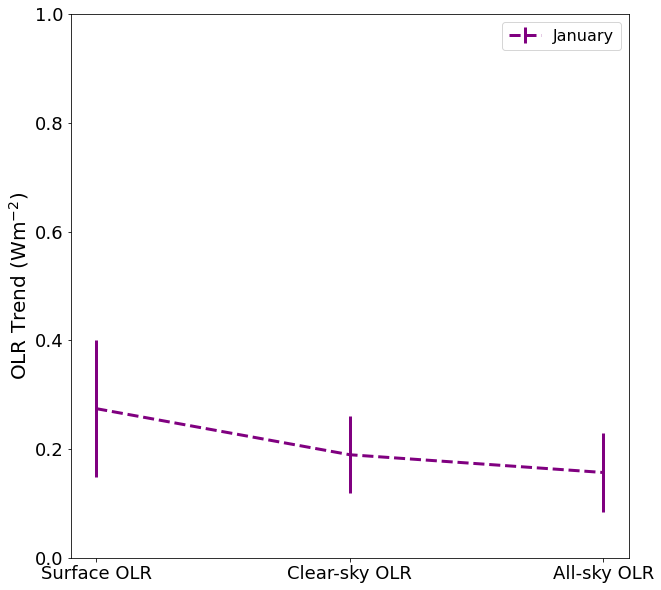

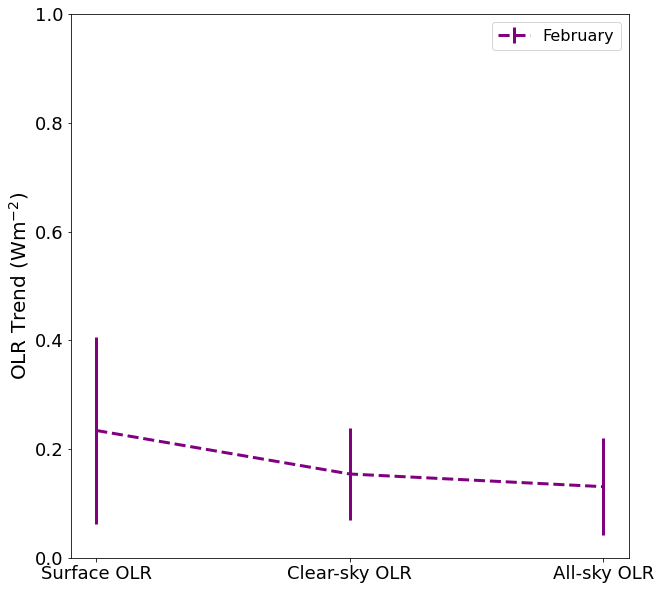

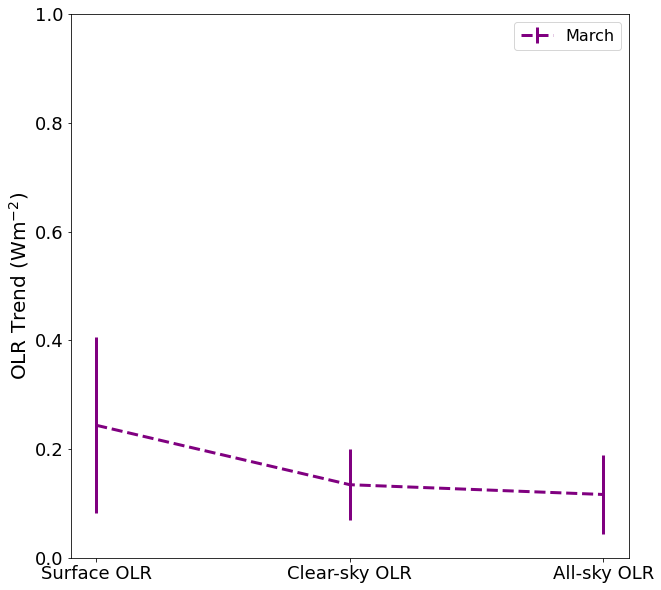

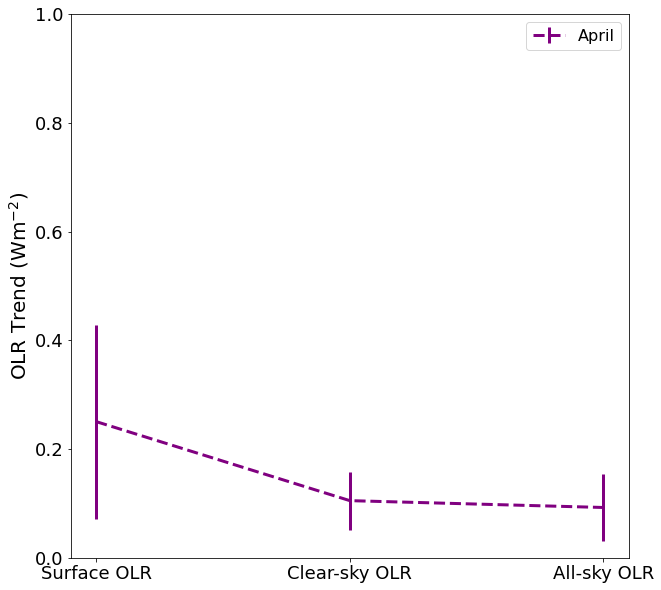

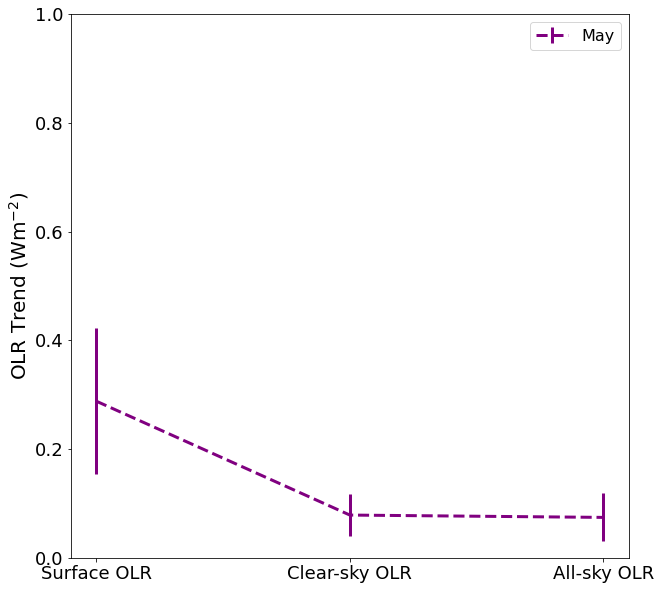

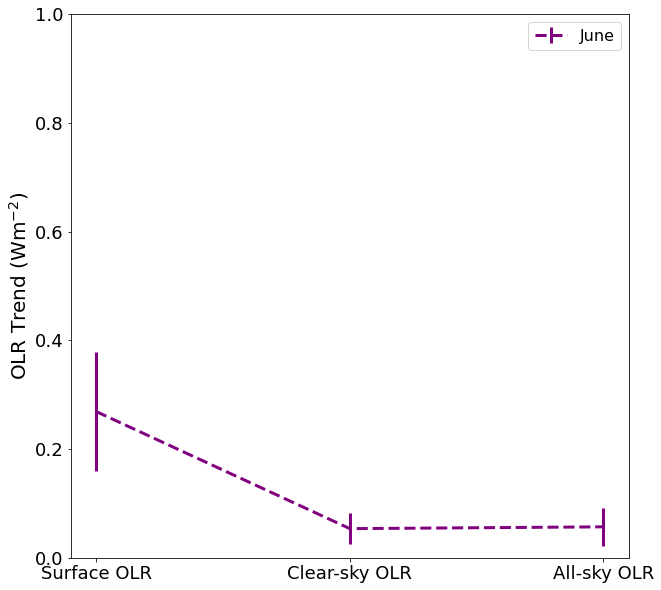

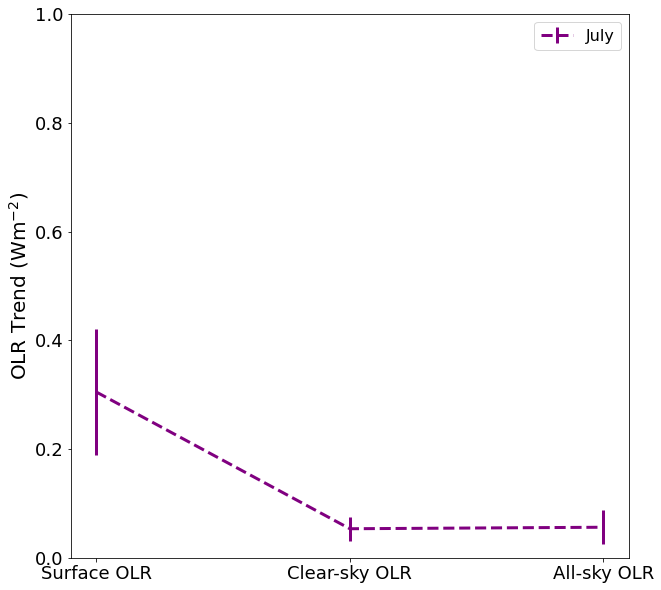

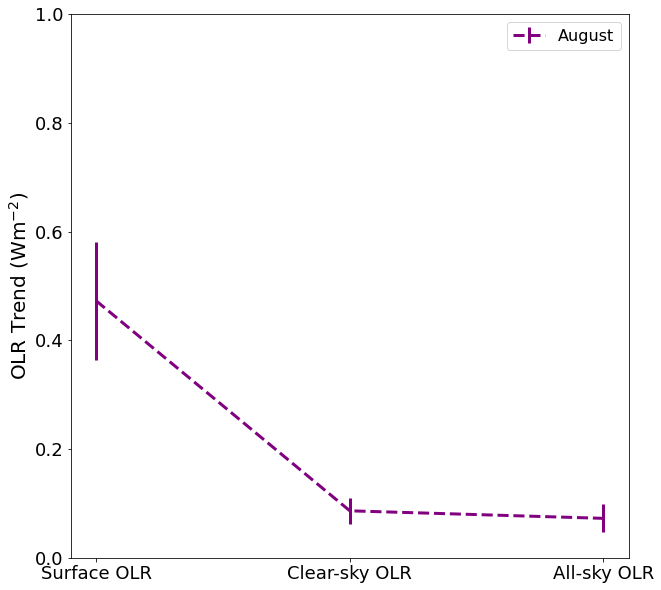

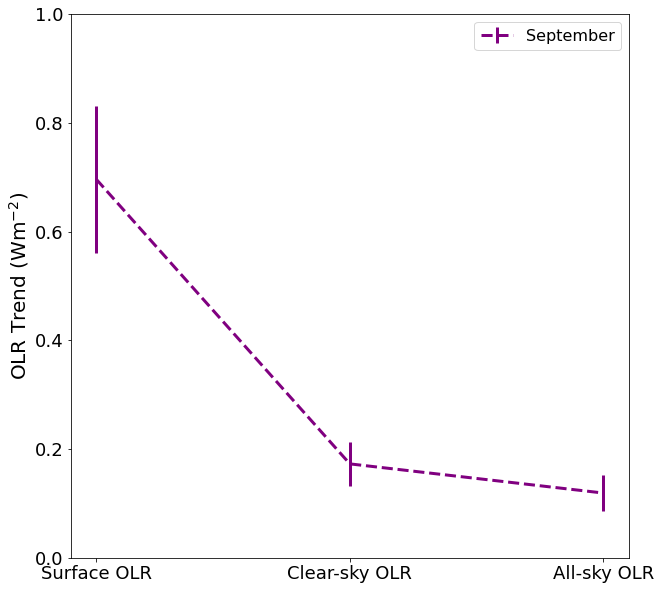

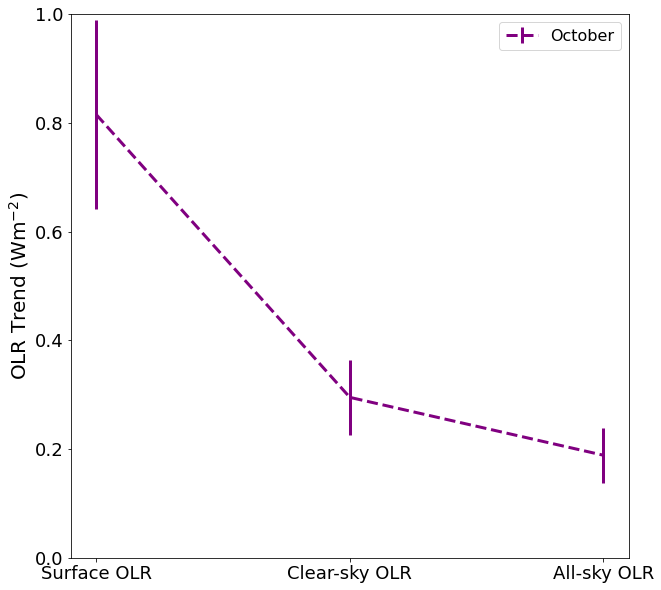

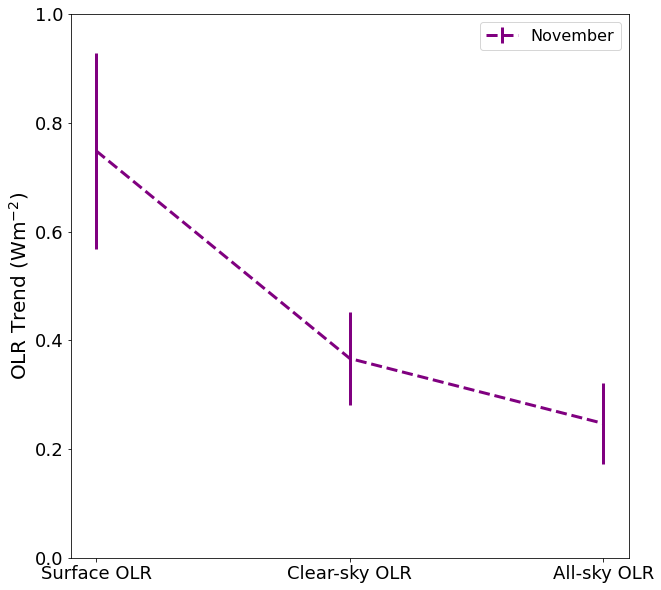

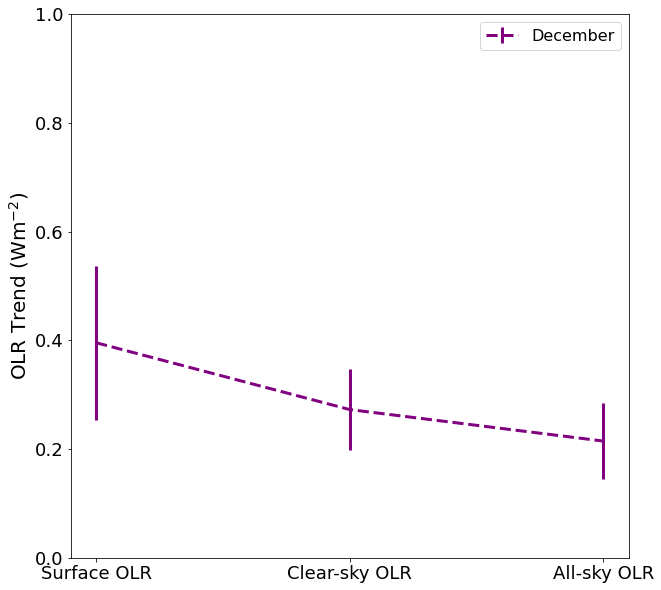

In [21]:

month_indices = np.arange(1,13)
month_names   = ['January','February','March','April','May','June','July','August','September','October','November','December']

for month_index,month_name in enumerate(month_names):
                 
    fig_50yr_sea,axs_50yr_seas = plt.subplots(1,1,figsize=(10,10))

    axs_50yr_seas.errorbar(x=[0,2,4],y=cesm1_all_2001_2050['olr'].sel(bound=2,month=month_index+1).values,yerr=cesm1_allerr_2001_2050.sel(month=month_index+1),
                      linestyle='dashed',label=month_name,color='purple',linewidth=3)

    axs_50yr_seas.set_xticks([0,2,4])
    axs_50yr_seas.set_xticklabels(['Surface OLR','Clear-sky OLR','All-sky OLR'],fontsize=18)

    axs_50yr_seas.legend(fontsize=16)
    axs_50yr_seas.set_ylim(0,1)
    axs_50yr_seas.tick_params(axis='y', labelsize=18)
    axs_50yr_seas.set_ylabel('OLR Trend (Wm$^{-2}$)',fontsize=20)
    
    to_png(fig_50yr_sea,filename='OLR_layers_%s'%(month_name),loc='/glade/u/home/jonahshaw/figures/OLR_layers_monthly/',dpi=300,ext='jpg')
    
    del axs_50yr_seas
    del fig_50yr_sea

#### Create a gif from those files

In [22]:
from PIL import Image

In [23]:
month_names   = ['January','February','March','April','May','June','July','August','September','October','November','December']

# Create the frames
save_dir = '/glade/u/home/jonahshaw/figures/OLR_layers_monthly/'

frames = []

for _month in month_names:    
    _file = glob.glob('%s/OLR_layers_%s.jpg' % (save_dir,_month))[0]

    # print(_file)
    
    new_frame = Image.open(_file)
    frames.append(new_frame)
    
#     break

In [24]:
# Save into a GIF file that loops forever
frames[0].save('%s/OLR_bylayer_monthly_jpg.gif' % save_dir, format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=600, loop=0)

#### Better figure for all months.

In [25]:
cesm1_all_2001_2050_wrapped = xr.concat([cesm1_all_2001_2050,cesm1_all_2001_2050.sel(month=1).assign_coords({'month':13})],dim='month')
cesm1_allerr_2001_2050_wrapped = xr.concat([cesm1_allerr_2001_2050,cesm1_allerr_2001_2050.sel(month=1).assign_coords({'month':13})],dim='month')

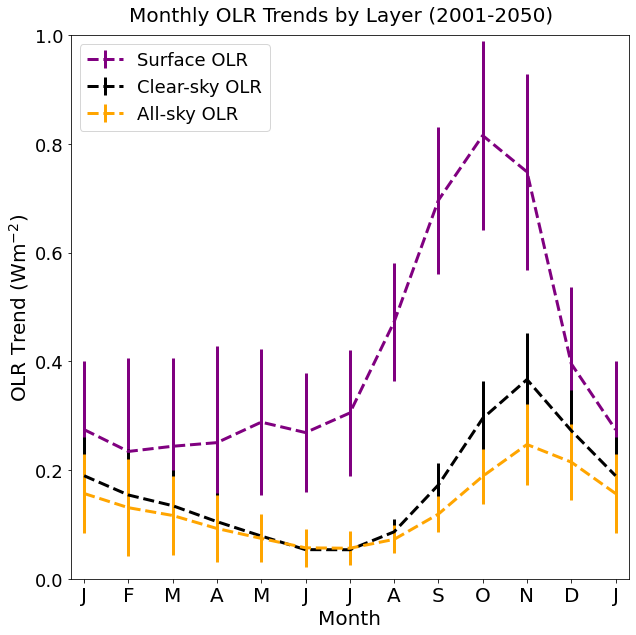

In [26]:
new_fig,new_ax = plt.subplots(1,1,figsize=(10,10))

new_ax.errorbar(x=np.arange(1,14),y=cesm1_all_2001_2050_wrapped['olr'].sel(variable='0FLUS',bound=2),yerr=cesm1_allerr_2001_2050_wrapped.sel(variable='0FLUS'),
                linestyle='dashed',label='Surface OLR',color='purple',linewidth=3)

new_ax.errorbar(x=np.arange(1,14),y=cesm1_all_2001_2050_wrapped['olr'].sel(variable='1FLUTC',bound=2),yerr=cesm1_allerr_2001_2050_wrapped.sel(variable='1FLUTC'),
                linestyle='dashed',label='Clear-sky OLR',color='black',linewidth=3)

new_ax.errorbar(x=np.arange(1,14),y=cesm1_all_2001_2050_wrapped['olr'].sel(variable='2FLUT',bound=2),yerr=cesm1_allerr_2001_2050_wrapped.sel(variable='2FLUT'),
                linestyle='dashed',label='All-sky OLR',color='orange',linewidth=3)

new_ax.set_xlim(0.7,13.3)
new_ax.set_ylim(0,1)
new_ax.tick_params(axis='y', labelsize=18)
new_ax.set_ylabel('OLR Trend (Wm$^{-2}$)',fontsize=20)

month_abbrevs = ['J','F','M','A','M','J','J','A','S','O','N','D','J']

new_ax.set_xticks(np.arange(1,14))
new_ax.set_xticklabels(month_abbrevs,fontsize=20)
new_ax.set_xlabel('Month',fontsize=20)

new_fig.suptitle('Monthly OLR Trends by Layer (2001-2050)',fontsize=20,y=0.92)

new_ax.legend(fontsize=18,loc='upper left')

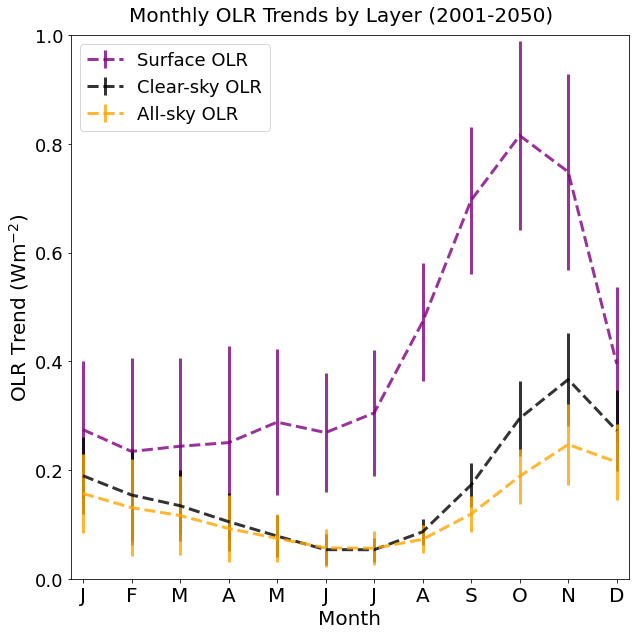

In [32]:
new_fig,new_ax = plt.subplots(1,1,figsize=(10,10))

new_ax.errorbar(x=np.arange(1,13),y=cesm1_all_2001_2050['olr'].sel(variable='0FLUS',bound=2),yerr=cesm1_allerr_2001_2050.sel(variable='0FLUS'),
                linestyle='dashed',label='Surface OLR',color='purple',linewidth=3,alpha=0.8)

new_ax.errorbar(x=np.arange(1,13),y=cesm1_all_2001_2050['olr'].sel(variable='1FLUTC',bound=2),yerr=cesm1_allerr_2001_2050.sel(variable='1FLUTC'),
                linestyle='dashed',label='Clear-sky OLR',color='black',linewidth=3,alpha=0.8)

new_ax.errorbar(x=np.arange(1,13),y=cesm1_all_2001_2050['olr'].sel(variable='2FLUT',bound=2),yerr=cesm1_allerr_2001_2050.sel(variable='2FLUT'),
                linestyle='dashed',label='All-sky OLR',color='orange',linewidth=3,alpha=0.8)

new_ax.set_ylim(0,1)
new_ax.tick_params(axis='y', labelsize=18)
new_ax.set_ylabel('OLR Trend (Wm$^{-2}$)',fontsize=20)

month_abbrevs = ['J','F','M','A','M','J','J','A','S','O','N','D','J']

new_ax.set_xticks(np.arange(1,13))
new_ax.set_xticklabels(month_abbrevs[:-1],fontsize=20)
new_ax.set_xlabel('Month',fontsize=20)
new_ax.set_xlim(0.75,12.25)

new_fig.suptitle('Monthly OLR Trends by Layer (2001-2050)',fontsize=20,y=0.92)

new_ax.legend(fontsize=18,loc='upper left')

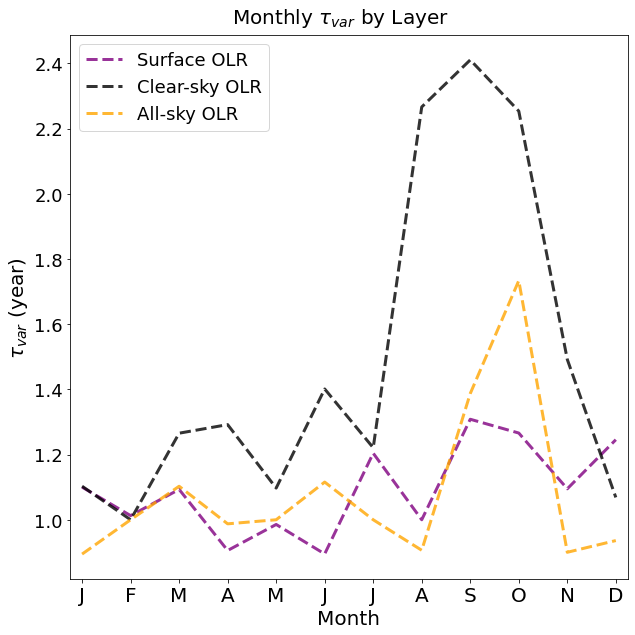

In [44]:
new_fig,new_ax = plt.subplots(1,1,figsize=(10,10))

new_ax.plot(np.arange(1,13),cesm1_olrs_tauvar,
            linestyle='dashed',label='Surface OLR',color='purple',linewidth=3,alpha=0.8)

new_ax.plot(np.arange(1,13),cesm1_olrc_tauvar,
            linestyle='dashed',label='Clear-sky OLR',color='black',linewidth=3,alpha=0.8)

new_ax.plot(np.arange(1,13),cesm1_olr_tauvar,
            linestyle='dashed',label='All-sky OLR',color='orange',linewidth=3,alpha=0.8)

# new_ax.set_ylim(0,1)
new_ax.tick_params(axis='y', labelsize=18)
new_ax.set_ylabel(r'$\tau_{var}$ (year)',fontsize=20)

month_abbrevs = ['J','F','M','A','M','J','J','A','S','O','N','D','J']

new_ax.set_xticks(np.arange(1,13))
new_ax.set_xticklabels(month_abbrevs[:-1],fontsize=20)
new_ax.set_xlabel('Month',fontsize=20)
new_ax.set_xlim(0.75,12.25)

new_fig.suptitle(r'Monthly $\tau_{var}$ by Layer',fontsize=20,y=0.92)

new_ax.legend(fontsize=18,loc='upper left')

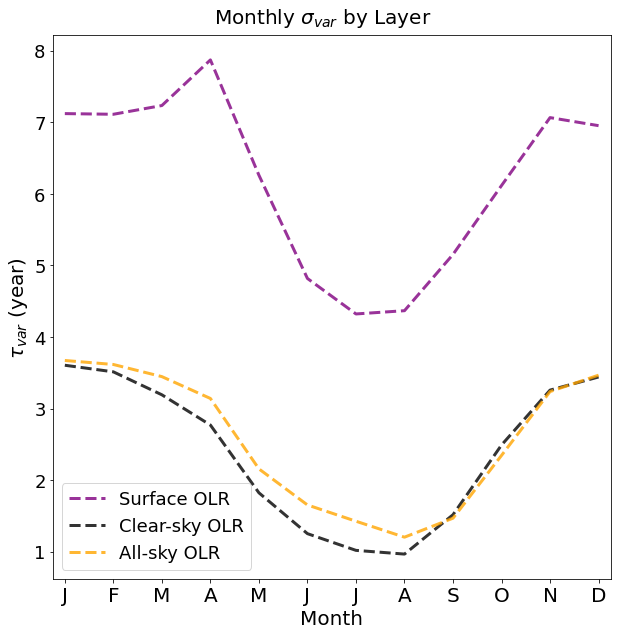

In [46]:
new_fig,new_ax = plt.subplots(1,1,figsize=(10,10))

new_ax.plot(np.arange(1,13),cesm1_olrs_stddev,
            linestyle='dashed',label='Surface OLR',color='purple',linewidth=3,alpha=0.8)

new_ax.plot(np.arange(1,13),cesm1_olrc_stddev,
            linestyle='dashed',label='Clear-sky OLR',color='black',linewidth=3,alpha=0.8)

new_ax.plot(np.arange(1,13),cesm1_olr_stddev,
            linestyle='dashed',label='All-sky OLR',color='orange',linewidth=3,alpha=0.8)

# new_ax.set_ylim(0,1)
new_ax.tick_params(axis='y', labelsize=18)
new_ax.set_ylabel(r'$\tau_{var}$ (year)',fontsize=20)

month_abbrevs = ['J','F','M','A','M','J','J','A','S','O','N','D','J']

new_ax.set_xticks(np.arange(1,13))
new_ax.set_xticklabels(month_abbrevs[:-1],fontsize=20)
new_ax.set_xlabel('Month',fontsize=20)
new_ax.set_xlim(0.75,12.25)

new_fig.suptitle(r'Monthly $\sigma_{var}$ by Layer',fontsize=20,y=0.92)

new_ax.legend(fontsize=18)#,loc='upper left')

### Remote and Radiative causes for different behavior in the shoulder seasons.

Look at water vapor and its relation to surface temperatures.

Look at clear-sky OLR and its relation to surface temperatures.

In [147]:
cesm1_ensresponse_ds['TMQ']

<xarray.DataArray 'TMQ' (ens: 40, time: 960)>
array([[ 2.771743,  2.621676,  2.483793, ...,  8.61719 ,  7.23211 ,  6.381164],
       [ 2.597689,  2.450122,  2.758257, ...,  9.251432,  6.93345 ,  5.48246 ],
       [ 2.908758,  3.312607,  3.28643 , ..., 10.117361,  6.714797,  5.171746],
       ...,
       [ 2.781782,  2.590809,  3.103248, ...,  9.818373,  7.475607,  5.318293],
       [ 2.437996,  2.517033,  3.320513, ...,  9.529604,  7.754422,  6.380779],
       [ 2.509544,  2.369133,  3.304181, ...,  9.628982,  7.562776,  5.633894]])
Coordinates:
  * time     (time) object 2001-01-01 00:00:00 ... 2080-12-01 00:00:00
  * ens      (ens) int64 1 2 3 4 5 6 7 8 9 ... 32 33 34 35 101 102 103 104 105

In [190]:
months_interest = [3,4,5,8,9,10]

TS_flattened  = {}
TMQ_flattened = {}
OLRc_flattened = {}
OLR_flattened = {}

for _mon in months_interest:
    TS_flattened[_mon]  = np.ndarray.flatten(cesm1_ensresponse_ds['TS'].sel(time=cesm1_ensresponse_ds['time.month']==_mon).values)
    TMQ_flattened[_mon] = np.ndarray.flatten(cesm1_ensresponse_ds['TMQ'].sel(time=cesm1_ensresponse_ds['time.month']==_mon).values)
    OLRc_flattened[_mon] = np.ndarray.flatten(cesm1_ensresponse_ds['FLUTC'].sel(time=cesm1_ensresponse_ds['time.month']==_mon).values)
    OLR_flattened[_mon] = np.ndarray.flatten(cesm1_ensresponse_ds['FLUT'].sel(time=cesm1_ensresponse_ds['time.month']==_mon).values)
    

Text(0, 0.5, 'All-sky OLR (Wm$^{-2}$)')

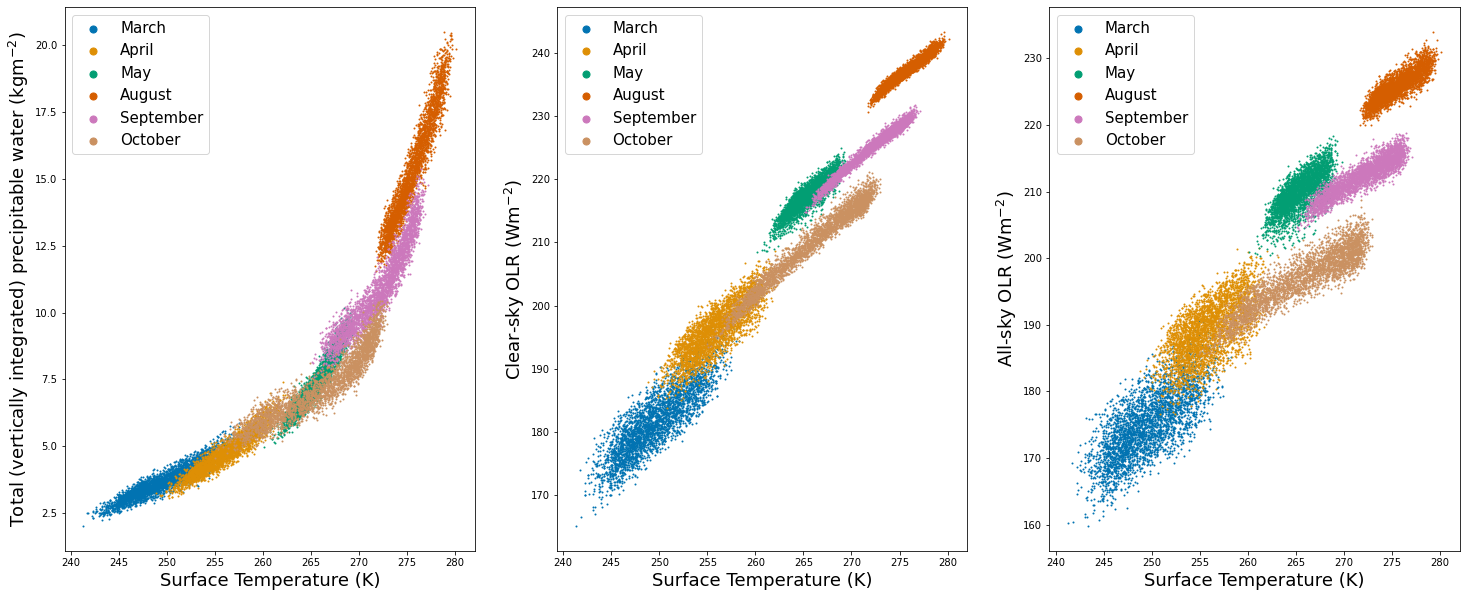

In [192]:
fig_WV,axs_WV = plt.subplots(1,3,figsize=(25,10))


colors = sns.color_palette("colorblind")
month_indices = [3,4,5,8,9,10]
month_names = ['March','April','May','August','September','October']

for _ind,month_name,_color in zip(month_indices,month_names,colors):
    axs_WV[0].scatter(TS_flattened[_ind],TMQ_flattened[_ind],
                      s=1,color=_color)
    axs_WV[0].scatter(None,None,label=month_name,
                      s=50,color=_color)

axs_WV[0].legend(fontsize=15)

axs_WV[0].set_xlabel('Surface Temperature (K)',fontsize=18)
axs_WV[0].set_ylabel('Total (vertically integrated) precipitable water (kgm$^{-2}$)',fontsize=18)

for _ind,month_name,_color in zip(month_indices,month_names,colors):
    axs_WV[1].scatter(TS_flattened[_ind],OLRc_flattened[_ind],
                      s=1,color=_color)
    axs_WV[1].scatter(None,None,label=month_name,
                      s=50,color=_color)

axs_WV[1].legend(fontsize=15)

axs_WV[1].set_xlabel('Surface Temperature (K)',fontsize=18)
axs_WV[1].set_ylabel('Clear-sky OLR (Wm$^{-2}$)',fontsize=18)

for _ind,month_name,_color in zip(month_indices,month_names,colors):
    axs_WV[2].scatter(TS_flattened[_ind],OLR_flattened[_ind],
                      s=1,color=_color)
    axs_WV[2].scatter(None,None,label=month_name,
                      s=50,color=_color)

axs_WV[2].legend(fontsize=15)

axs_WV[2].set_xlabel('Surface Temperature (K)',fontsize=18)
axs_WV[2].set_ylabel('All-sky OLR (Wm$^{-2}$)',fontsize=18)

I am seeing different relationships between surface temperature in spring versus the fall. But I am also seeing different relationships within the spring and fall seasons. I am trying to make sense of this...

What is the effect of using monthly averages? __We may be seeing variables overlap that don't actually. We're also comparing the 2001 of one month to the 2080 of another.__

Could remove the clouds by subtracting this variable:

TGCLDCWP (kgm$^{-2}$): Total grid-box cloud water path (liquid and ice)

from the TMQ:  

TMQ (kgm$^{-2}$): Total (vertically integrated) precipitable water

__First panel:__

Comparing May and October (where temperatures are similar), there is a different relationship between temperature and the column water content. Steeper slow in the spring (i.e. an equal surface temperature anomaly would be associated with a greater water vapor anomaly.

This could have to do with more vertical mixing (i.e. temperature changes in the spring are less confined to surface than in the fall, but this shouldn't be true).

__Second Panel:__

In the second panel, we see a nearly linear relationship between surface temperature and clear-sky OLR within individual months. If we had daily output, however, I expect that there would be some exponential behavior.

Again comparing May and October, there is greater clear-sky OLR in May than October despite similar surface temperatures. _This cannot be explained by the water vapor differences because there is more water vapor in May._ So the emission just must be coming from the atmosphere rather than the surface. This makes sense because inversions are more characteristic of the spring than the fall where the ocean surface is open.

__Third Panel:__

This looks very similar to the second panel, which is good! By adding clouds we're additionally now seeing the OLR response to surface temperature change as less in the fall than in the spring, showing the moderating effect of the cloud response to sea ice loss in warmer climates.

Another interesting result is that clouds are adding variability (scatter) in the fall, much more than in the spring.

Taken together, this paints a picture of surface-driven OLR in the Fall and atmosphere-driven OLR in the Spring. Perhaps this isn't surprising? Also it explains the greater variability in the spring relative to the fall just based on thermal inertia of the surface vs. the atmosphere.

Text(0, 0.5, 'All-sky OLR (Wm$^{-2}$)')

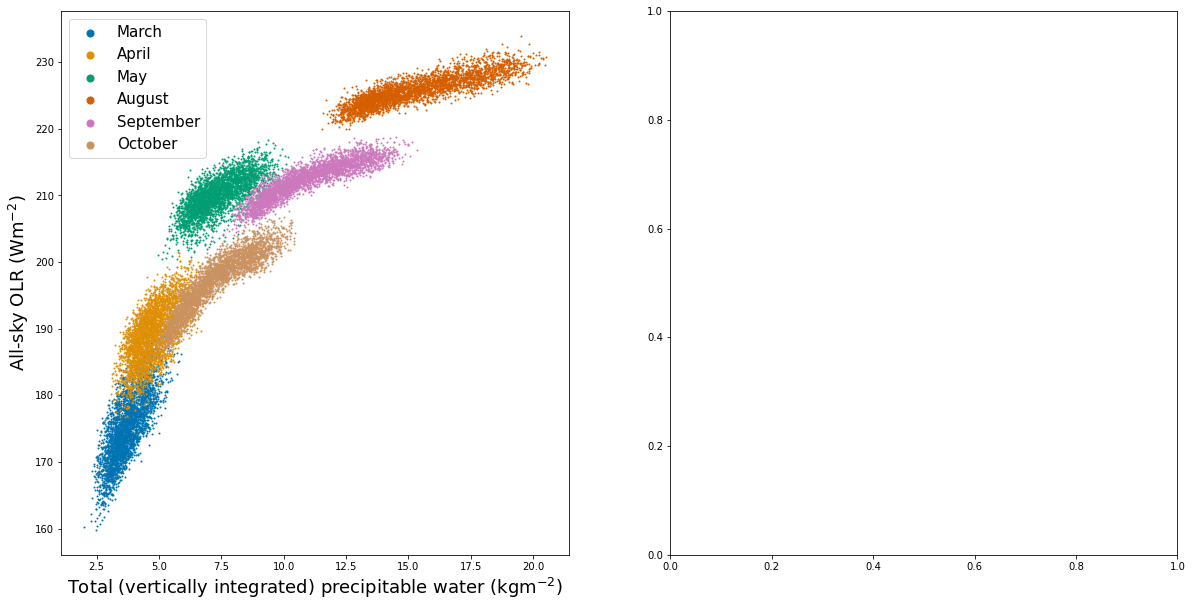

In [194]:
fig_WV,axs_WV = plt.subplots(1,2,figsize=(20,10))


colors = sns.color_palette("colorblind")
month_indices = [3,4,5,8,9,10]
month_names = ['March','April','May','August','September','October']

for _ind,month_name,_color in zip(month_indices,month_names,colors):
    axs_WV[0].scatter(TMQ_flattened[_ind],OLR_flattened[_ind],
                      s=1,color=_color)
    axs_WV[0].scatter(None,None,label=month_name,
                      s=50,color=_color)

axs_WV[0].legend(fontsize=15)

axs_WV[0].set_xlabel('Total (vertically integrated) precipitable water (kgm$^{-2}$)',fontsize=18)
axs_WV[0].set_ylabel('All-sky OLR (Wm$^{-2}$)',fontsize=18)

# for _ind,month_name,_color in zip(month_indices,month_names,colors):
#     axs_WV[1].scatter(TS_flattened[_ind],OLR_flattened[_ind],
#                       s=1,color=_color)
#     axs_WV[1].scatter(None,None,label=month_name,
#                       s=50,color=_color)

# axs_WV[1].legend(fontsize=15)

# axs_WV[1].set_xlabel('Surface Temperature (K)',fontsize=18)
# axs_WV[1].set_ylabel('All-sky OLR (Wm$^{-2}$)',fontsize=18)

### OLD

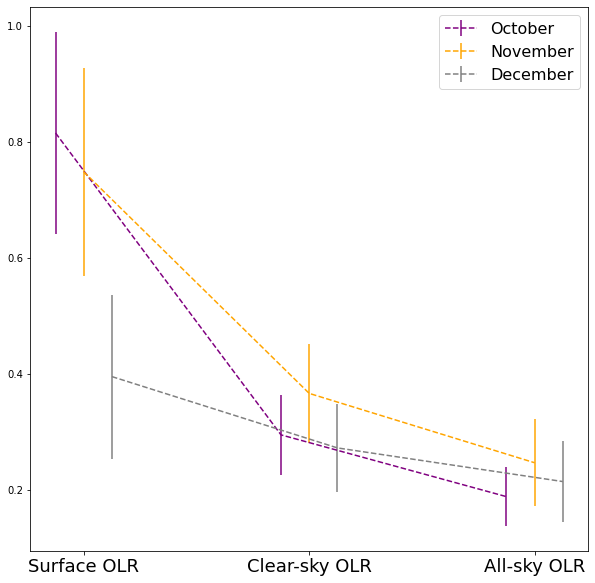

In [109]:
fig_50yr,axs_50yr = plt.subplots(1,1,figsize=(10,10))

month_indices = [10,11,12]
month_names   = ['October','November','December']

axs_50yr.errorbar(x=[-0.25,1.75,3.75],y=cesm1_all_2001_2050['olr'].sel(bound=2,month=month_indices[0]).values,yerr=cesm1_allerr_2001_2050.sel(month=month_indices[0]),
                  linestyle='dashed',label=month_names[0],color='purple')

axs_50yr.errorbar(x=[0,2,4],y=cesm1_all_2001_2050['olr'].sel(bound=2,month=month_indices[1]).values,yerr=cesm1_allerr_2001_2050.sel(month=month_indices[1]),
                  linestyle='dashed',label=month_names[1],color='orange')

axs_50yr.errorbar(x=[0.25,2.25,4.25],y=cesm1_all_2001_2050['olr'].sel(bound=2,month=month_indices[2]).values,yerr=cesm1_allerr_2001_2050.sel(month=month_indices[2]),
                  linestyle='dashed',label=month_names[2],color='grey')

axs_50yr.set_xticks([0,2,4])
axs_50yr.set_xticklabels(['Surface OLR','Clear-sky OLR','All-sky OLR'],fontsize=18)

axs_50yr.legend(fontsize=16)

Strong cloud damping effect in October. Minimal atmospheric effect in December.